In [135]:
import os
import numpy
from scipy.interpolate import interp1d

root = 'logs/'
algos = ['a2c', 'acktr', 'ppo']
games = ['beamrider', 'breakout', 'qbert']
numTrials = 5

def getLogFileNames(trialName):
    folderPath = root + trialName
    logFileNames = [fileName for fileName in os.listdir(folderPath) if 'monitor' in fileName]
    return folderPath, logFileNames
    
def getTrialStats(trialName):
    folderPath, logFileNames = getLogFileNames(trialName)
    
    logs = []
    for fileName in logFileNames:
        filePath = folderPath + '/' + fileName
        log_lines = []
        with open(filePath, 'r') as log_file:
            log_lines = log_file.readlines()
        logs.append(log_lines[2:])

    numProcesses = len(logs)
    timeSteps = []
    rewards = []
    for log in logs:
        curTimeStep = 0
        for line in log:
            lineParts = line.split(',')
            episodeReward = float(lineParts[0])
            episodeSteps = int(lineParts[1])
            episodeTime = float(lineParts[2])
            curTimeStep += episodeSteps * numProcesses
            timeSteps.append(curTimeStep)
            rewards.append(episodeReward)

    return timeSteps, rewards

def standardize_times(times):
    startTime = times[0]
    endTime = times[-1]
    #numTimes = len(times)
    numTimes = 3000
    return numpy.linspace(startTime, endTime, numTimes)

def standardize_rewards(standardTimes, times, rewards):
    f = interp1d(times, rewards, kind='nearest')
    return f(standardTimes)

In [136]:
trialNames = []
for algo in algos:
    for game in games:
        for trialNum in range(1, numTrials + 1):
            trialStr = str(trialNum)
            trialName = algo + '_' + game + '_' + trialStr
            trialNames.append(trialName)

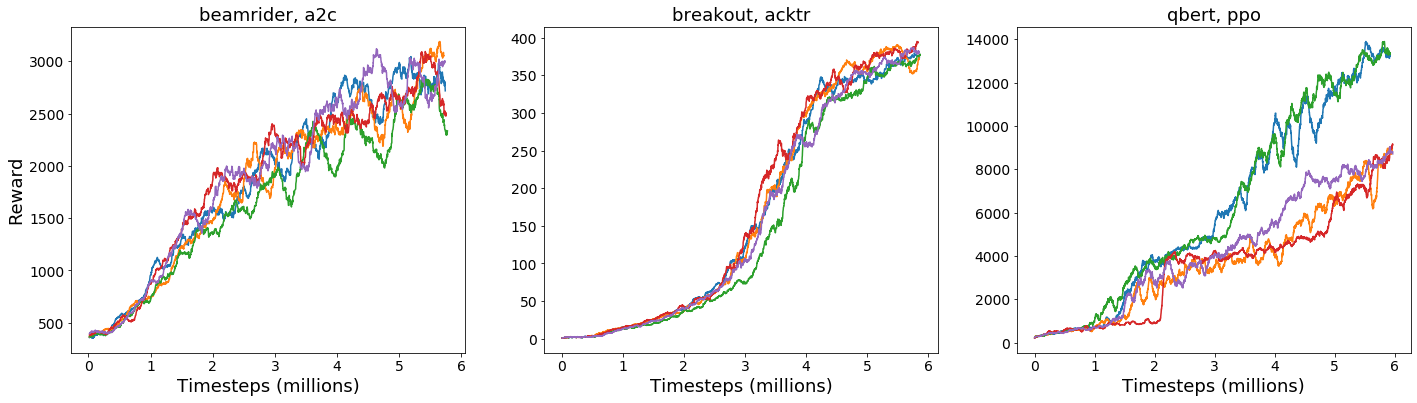

In [137]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 24, 6 #width, height

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

fig, axs = plt.subplots(1, 3)  
for i, algo in enumerate(algos):
    game = games[i]
    
    ax = axs[i]
    ax.set_title(game + ', ' + algo, fontsize=18)
    
    for trialNum in range(1, numTrials + 1):
        trialNumStr = str(trialNum)
        trialName = algo + '_' + game + '_' + trialNumStr
        times, rewards = getTrialStats(trialName)
        times, rewards = zip(*sorted(zip(times, rewards)))
        rewardsWindow = running_mean(numpy.array(rewards), 100)
        ax.plot(numpy.array(times[:-99]) / 1e6, numpy.array(rewardsWindow))
        
    ax.set_xlabel('Timesteps (millions)', fontsize=18)
    if i == 0:
        ax.set_ylabel('Reward', fontsize=18) 
    ax.tick_params(axis='both', which='major', labelsize=14)
        
plt.show()